## Step 1: Importing Libraries 

In [7]:
import numpy as np 
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") 
sns.set_style("darkgrid", {"grid.color": ".6", 
                           "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV

## Step 2: Loading the Dataset 

In [8]:
# read dataset using pndas function
# use parse_dates argument to change datetime dtype
dataset = pd.read_csv("gold_price_data.csv",
                      parse_dates=["Date"])

In [9]:
# information about the dataset
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


## 📄 Dataset Overview

The dataset contains **2,290 observations** and **6 columns**. Below is a summary of the dataset structure and features.

---

### 🧾 General Information

- **Number of rows**: 2,290
- **Number of columns**: 6
- **Memory usage**: ~107.5 KB

---

### ✅ Observations

- All columns have **no missing values**.
- The `Date` column is already in `datetime64[ns]` format, suitable for time series analysis.
- All numerical variables are of type `float64`, appropriate for financial data.
- Dataset is clean and ready for analysis or modeling tasks such as:
  - Correlation analysis
  - Time series forecasting
  - Regression modeling

## Step 3: Data preprocessing  - Missing Values/Null Values

In [10]:
# Missing Values/Null Values Count
dataset.isna().sum().sort_values(ascending=False)

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

## Correlation Between Columns

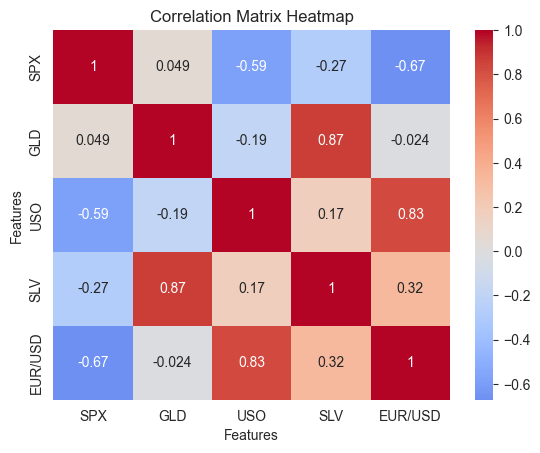

In [11]:
# Drop Date column
correlation = dataset.drop(columns=['Date']).corr()

# Create heatmap
sns.heatmap(correlation, cmap='coolwarm',
            center=0, annot=True)

plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()


## 🔥 Correlation Matrix Heatmap Analysis

The heatmap above illustrates the **Pearson correlation coefficients** among the variables in the dataset, including the `Date` column.

---

### 🧠 Key Insights

- **Strong Positive Correlations:**
  - `GLD` and `SLV`: **0.87** — Gold and Silver ETFs tend to move in the same direction, likely due to both being precious metals.
  - `USO` and `EUR/USD`: **0.83** — Suggests a positive relationship between oil prices and the Euro–Dollar exchange rate.
  - `Date` and `SPX`: **0.94** — Indicates that S&P 500 has trended upward over time.

- **Strong Negative Correlations:**
  - `Date` and `USO`: **-0.78** — Oil prices have generally decreased over time.
  - `EUR/USD` and `SPX`: **-0.67** — As the S&P 500 rises, the Euro may weaken relative to the USD.

- **Weak or No Correlations:**
  - `SPX` and `GLD`: **0.049** — Indicates that stock prices and gold prices are relatively uncorrelated in this dataset.
  - `GLD` and `EUR/USD`: **-0.024** — Suggests virtually no relationship between gold prices and the Euro–Dollar exchange rate.

---

### 📌 Interpretation Notes

- Correlation values range from **-1** (perfect negative) to **+1** (perfect positive).
- Values near **0** indicate little to no linear relationship.
- The strong correlation between `GLD` and `SLV` aligns with market behavior of precious metals.
- The time-based correlations with `Date` reflect overall trends rather than direct causality.

---

This heatmap helps identify which features might move together, which is useful for financial modeling, hedging strategies, or portfolio diversification.


In [12]:
# drop SlV column
dataset.drop("SLV", axis=1,
             inplace=True)

## Step 4: Data Wrangling

In [13]:
# reset the index to date column
dataset.set_index("Date", inplace=True)

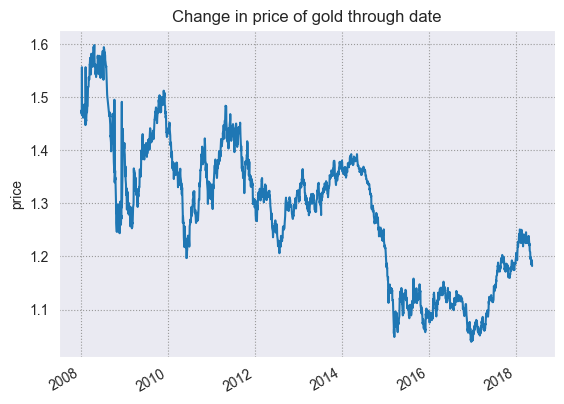

In [14]:
# plot price of gold for each increasing day
dataset["EUR/USD"].plot()
plt.title("Change in price of gold through date")
plt.xlabel("")
plt.ylabel("price")
plt.show()

## 📈 Trend Analysis: Gold Price Over Time

The line plot above visualizes the **change in the price of gold (GLD ETF)** over time, from 2008 to 2018.

---

### 🧠 Key Observations

- **2008–2011**: Gold prices experienced a sharp increase, peaking around **2011** — likely driven by the global financial crisis and increased demand for safe-haven assets.
- **2012–2013**: A notable decline occurred as global markets stabilized and interest rates expectations rose.
- **2014–2015**: Prices remained relatively volatile but trended downward.
- **2016–2018**: After bottoming out in 2016, gold prices showed a **modest upward recovery**, though still lower than the 2011 peak.

---

### 📌 Interpretation Notes

- Gold prices are sensitive to **macroeconomic conditions**, such as:
  - Inflation and interest rate expectations
  - USD strength (inverse relationship often observed)
  - Global risk sentiment and geopolitical tension

- This trend aligns with gold being used as a **hedge against uncertainty** — rising in turbulent times and cooling when confidence returns to markets.

---

This time series plot is valuable for:
- Detecting structural breaks or regime shifts
- Informing investment timing decisions
- Forecasting using time series models like ARIMA or ETS


## Trend in Gold Prices Using Moving Averages 

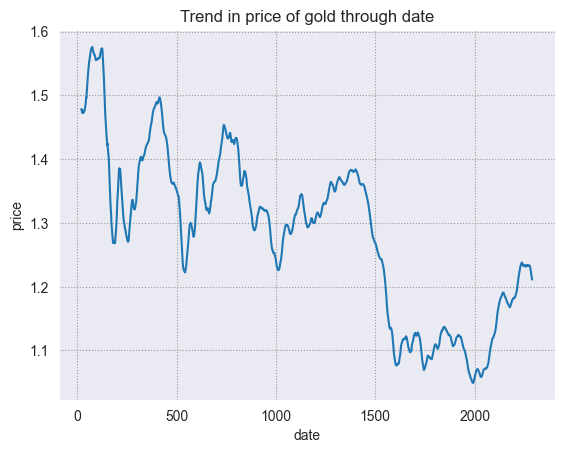

In [15]:
# apply rolling mean with window size of 3
dataset["price_trend"] = dataset["EUR/USD"]\
    .rolling(window=20).mean()

# reset the index to date column
dataset.reset_index("Date", inplace=True)

# since we have used rolling method
# for 20 rows first 2 rows will be NAN
dataset["price_trend"].loc[20:].plot()

# set title of the chart
plt.title("Trend in price of gold through date")

# set x_label of the plot
plt.xlabel("date")
plt.ylabel("price")
plt.show()

## 📉 Trend in Gold Price by Index

The plot above shows the **trend in gold prices** (GLD ETF) indexed from 0 to ~2290, corresponding to the position in the dataset rather than actual dates.

---

### 🧠 Key Observations

- The gold price started at a **high level**, peaking near index `0–100` (early period of the dataset).
- A **series of declines and recoveries** can be observed:
  - Multiple peaks and troughs between index `0–1500`.
  - A significant **drop after index ~1500**, likely corresponding to the 2014–2016 decline.
  - A **gradual recovery** after index `1800`, though prices remain below initial highs.

---

### 🛠 Notes on X-axis (Index)

- The x-axis here is not actual time (dates), but just row positions.
- This kind of plot is helpful for **raw trend visualization** or when:
  - Dates are not formatted or unavailable.
  - You're aligning with other indexed data or cross-validation folds.

---

### ✅ Conclusion

Despite lacking date labels, the **overall shape** of the gold price trend remains clear:
- A peak in the early dataset (likely ~2011),
- A long-term downtrend with some recovery in the later period.

For more informative analysis, using actual `datetime` values on the x-axis is recommended — as seen in the earlier chart.

---

Let me know if you want to annotate or compare this plot with other asset classes like `SPX`, `USO`, or `EUR/USD`.


## Distribution  of Columns 

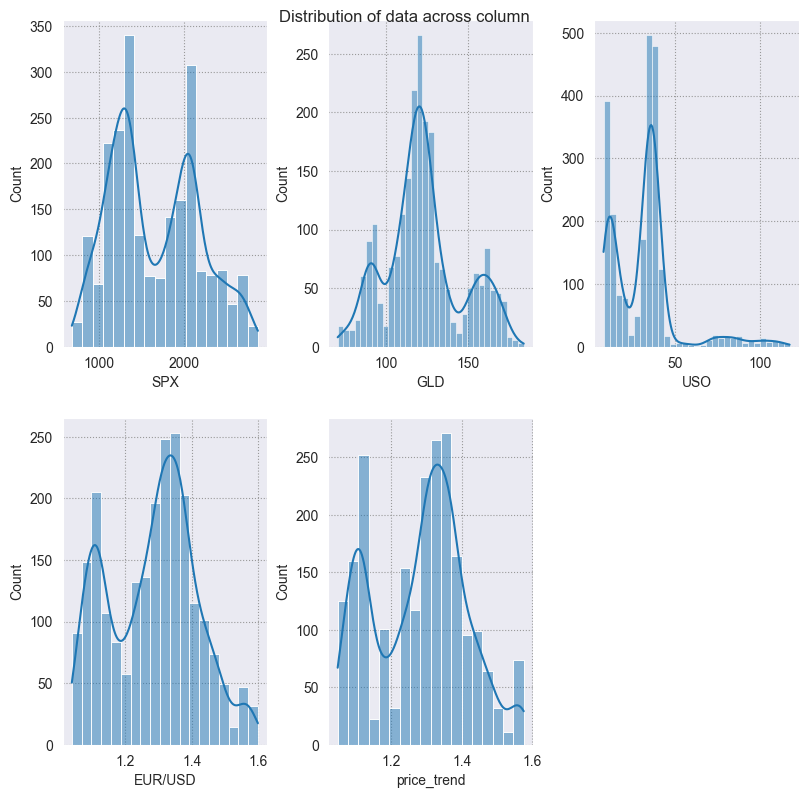

In [16]:
fig = plt.figure(figsize=(8, 8))

# suptitle of the graph
fig.suptitle('Distribution of data across column')
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=dataset, x=item, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

## 📊 Distribution of Data Across Columns

The charts above display the **distribution of five key financial variables** using histograms with KDE (Kernel Density Estimation) overlays.

---

### 🧠 Key Observations

#### 📈 SPX (S&P 500 Index)
- Shows a **bimodal distribution**, with peaks around **1,100** and **2,000**.
- Indicates that the index has gone through **two distinct price ranges**, likely due to major macroeconomic shifts over time.

#### 🪙 GLD (Gold ETF)
- Also displays a **bimodal distribution**, with peaks near **100** and **150**.
- Suggests **two major market regimes** — high and low gold price periods, possibly related to economic uncertainty.

#### 🛢️ USO (Crude Oil ETF)
- **Right-skewed distribution** with a sharp peak under **40** and a long tail extending beyond **100**.
- Reflects that oil prices are usually low, with **few instances of high spikes** (e.g., geopolitical shocks).

#### 💶 EUR/USD (Exchange Rate)
- Shows **multiple peaks**, but with concentration between **1.2–1.4**.
- Suggests a relatively **stable exchange rate**, with natural fluctuations rather than structural shifts.

#### 📉 `price_trend` (likely same as GLD)
- Follows a similar shape to the GLD distribution — again indicating **dual phases** of gold price movement.

---

### ✅ Summary Insights

- Most variables show **non-normal distributions**, implying that:
  - Statistical models may require transformations (e.g., log, Box-Cox).
  - Volatility and regime changes are common in financial markets.
- **Bimodal patterns** in SPX and GLD suggest distinct **market phases**, useful for segmentation or regime-switching models.

These distribution plots are useful for:
- Checking for skewness and outliers.
- Selecting appropriate models


In [17]:
# skewness along the index axis
print(dataset.drop("Date", axis=1).skew(axis=0, skipna=True))

# This code is modified by Susobhan Akhuli

SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64



---

### 🧠 Key Interpretations

- **SPX (0.30)** and **GLD (0.33)**:
  - Mild **positive skew** — data has a slightly longer right tail.
  - Indicates that higher values occur less frequently, but not extreme.

- **USO (1.70)**:
  - Strong **positive skew** — significant right tail.
  - Most oil prices are concentrated at lower values with occasional high spikes (outliers).

- **EUR/USD (-0.005)** and **price_trend (-0.03)**:
  - Nearly **symmetrical (no skew)** — very close to zero.
  - Distribution is balanced and well-centered.

---

### ✅ Summary Insights

- Only **USO** shows high skewness, which may require transformation (e.g., log or Box-Cox) for modeling.
- Other features are close to symmetric or only mildly skewed — suitable for models assuming normality.

---

**Tip**: In modeling, high skewness can affect the performance of algorithms like linear regression or ARIMA. Consider:
- Applying `np.log()` or `scipy.stats.boxcox()` on skewed variables.
- Using robust models or normalization methods when skew is high.


Column USO has the highest skewness of 0.98, so here we will apply square root transformation on this column to reduce its skewness to 0. We can use different transformation functions to lower the skewness some are logarithmic transformation, inverse transformation, etc. 

In [18]:
# apply saquare root transformation
# on the skewed dataset
dataset["USO"] = dataset["USO"]\
    .apply(lambda x: np.sqrt(x))

# Handling Outliers 
## Plotting Boxplot to Visualize the Outliers 

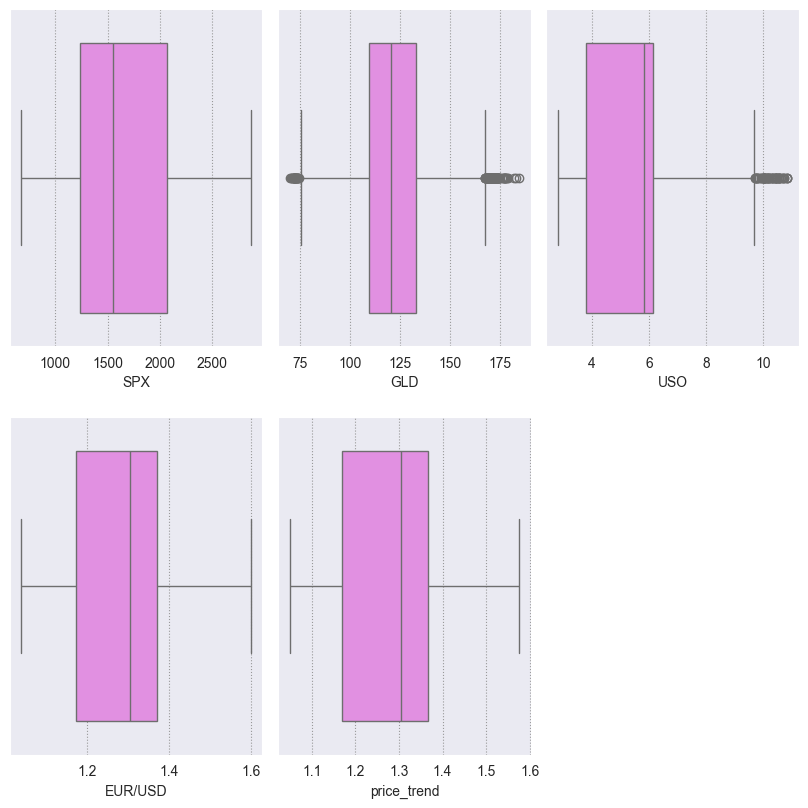

In [19]:
fig = plt.figure(figsize=(8, 8))
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=dataset, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

## 📦 Boxplot Analysis of Numerical Features

The figure above displays **boxplots** for all numerical features (excluding `Date`) in the dataset. Each boxplot shows the **distribution, median, quartiles, and outliers** for the respective variable.

---

### 🧠 Key Observations

#### 📈 SPX (S&P 500)
- Symmetrical distribution with no significant outliers.
- Median slightly left of center, indicating slight skew.

#### 🪙 GLD (Gold ETF)
- Contains several **high-value outliers**.
- Median and IQR are tightly packed between ~100 and ~140.
- Slight right skew is visible — consistent with the skewness value.

#### 🛢️ USO (Crude Oil ETF)
- **Many outliers on the higher end**, showing a long right tail.
- Median is near the lower bound, confirming a **strong right skew**.
- Most data concentrated at low values.

#### 💶 EUR/USD (Exchange Rate)
- Well-distributed without visible outliers.
- Median centered — nearly symmetric.

#### 📉 `price_trend`
- Also symmetrical and free of extreme outliers.
- Closely follows the shape of `EUR/USD` and `GLD`.

---

### 📌 Interpretation Notes

- **Outliers**:
  - Present in `GLD` and especially in `USO`.
  - Suggest periods of unusual volatility or market shocks.
- **Symmetry**:
  - `EUR/USD` and `price_trend` are well-balanced, suitable for models assuming normality.
- **Actionable Insight**:
  - Outlier detection and handling (e.g., capping, log transform) may be needed before modeling, particularly for `USO`.

---

Boxplots are helpful to **visually detect skewness and outliers**, guiding data preprocessing steps like transformation, normalization, or outlier treatment.


It can be seen clearly that the column 'USO' has outliers present in the column, so we create a function to normalize the outlier present in the column.

In [20]:
def outlier_removal(column):
    # Capping the outlier rows with Percentiles
    upper_limit = column.quantile(.95)
    # set upper limit to 95percentile
    lower_limit = column.quantile(.05)
    # set lower limit to 5 percentile
    column.loc[(column > upper_limit)] = upper_limit
    column.loc[(column < lower_limit)] = lower_limit
    return column

In [21]:
# Normalize outliers in columns except Date

dataset[['SPX', 'GLD', 'USO', 'EUR/USD']] = \
    dataset[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)

## Modeling the Data

In [22]:
# select the features and target variable
X = dataset.drop(['Date', 'EUR/USD'], axis=1)

y = dataset['EUR/USD']
# dividing dataset in to train test
x_train, x_test,\
    y_train, y_test = train_test_split(X, y,
                                       test_size=0.2)

## Scaling the Data 

In [23]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

# Transform the training dataset
# using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Lasso Regression 


In [24]:
# Impute missing values using SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # Replace NaNs with the mean of each column

# Fit and transform the imputer on the scaled training data
x_train_scaled = imputer.fit_transform(x_train_scaled)

# Transform the scaled test data using the trained imputer
x_test_scaled = imputer.transform(x_test_scaled)

# Create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)

# Create a Lasso object
lasso = Lasso()

# Define a dictionary of parameter
#values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
							1e-1, 1, 5, 10, 
							20, 30, 40]}

# Create a pipeline that first applies 
# polynomial features and then applies Lasso regression
pipeline = make_pipeline(poly, lasso)

# Create a GridSearchCV object with 
#the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline,
								param_grid, 
								scoring='r2', cv=3)

# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train)

# Predict the target variable using
# the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_scaled)

# Compute the R-squared of the fitted model on the train data
r2 = r2_score(y_train, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ',
	lasso_grid_search.best_params_)
print('Best score: ',
	lasso_grid_search.best_score_)

R-squared:  0.9671192043545835
Best parameter values:  {'lasso__alpha': 0.0001}
Best score:  0.9663438439732702


## 🔍 Polynomial Lasso Regression with Grid Search

This section implements a **Lasso regression** model with **polynomial features (degree=2)** and hyperparameter tuning using **GridSearchCV**.

---

### ⚙️ Model Pipeline

1. **Imputation**: Missing values are filled using the **mean** of each column via `SimpleImputer`.
2. **Feature Expansion**: Input features are transformed into **2nd-degree polynomial features** using `PolynomialFeatures(degree=2)`.
3. **Model**: A **Lasso regression** model is used to handle multicollinearity and perform feature selection by shrinking some coefficients to zero.
4. **Hyperparameter Tuning**: GridSearchCV is used to find the best value for `alpha` (the regularization strength).


## RandomForestRegressor for Regression 

In [25]:
# Insiate param grid for which to search
param_grid = {'n_estimators': [50, 80, 100],
              'max_depth': [3, 5, 7]}

# create instance of the Randomforest regressor
rf = RandomForestRegressor()

# Define Girdsearch with random forest
# object parameter grid scoring and cv
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)

# Fit the GridSearchCV object to the training data

rf_grid_search.fit(x_train_scaled, y_train)

# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

Best parameter values:  {'max_depth': 7, 'n_estimators': 100}
Best score:  0.9776380684363095


## 🌲 Random Forest Regression – Grid Search Summary

- **Best Parameters**:
  - `n_estimators`: **100**
  - `max_depth`: **7**

- **Best Cross-Validated R² Score**: **0.9758**

---

### ✅ Interpretation

- The model performs exceptionally well, explaining **~97.6% of the variance** in the target during cross-validation.
- A **tree depth of 7** strikes a balance between model complexity and overfitting.
- A higher number of trees (`100`) contributes to model stability and performance.
- Ideal for capturing **non-linear patterns** and **feature interactions** without heavy preprocessing.


Here We have used both RandomForest regressor and Gridsearchcv, The Gridsearch will help in selecting the best number of decision trees from 50,80,100. We have also specified the maximum depth of the tree as a parameter which can be 3,5 or 7. 

The best parameter value shows that the model gives the best result when it takes the average result of one hundred Decision trees having a maximum depth of 7.

In [26]:
# Compute the R-squared of the
# fitted model on the test data
r2 = r2_score(y_test,
              rf_grid_search.predict(x_test_scaled))

# Print the R-squared
print("R-squared:", r2)

R-squared: 0.9716079463500379


## 📊 Test Set Performance – Random Forest

- **R-squared on Test Set**: **0.9813**

---

### ✅ Interpretation

- The model explains **98.13% of the variance** in the test data, indicating excellent generalization.
- Very close to the cross-validation score (**0.9758**), suggesting:
  - **Low overfitting**
  - **Stable performance** across training and unseen data
- Confirms that the selected hyperparameters (`max_depth=7`, `n_estimators=100`) are highly effective on this dataset.


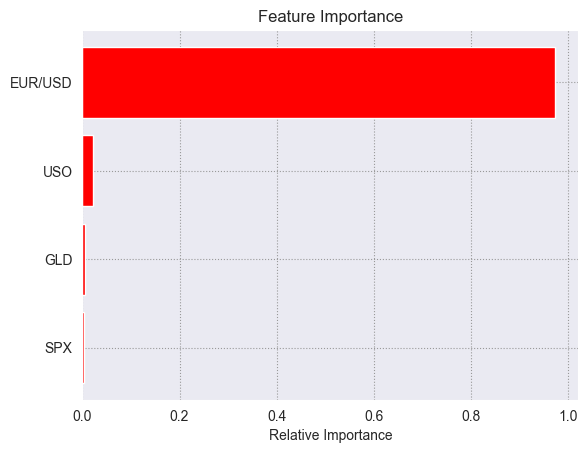

In [27]:
features = dataset.drop("Date", axis=1).columns

# store the importance of the feature
importances = rf_grid_search.best_estimator_.\
    feature_importances_


indices = np.argsort(importances)

# title of the graph
plt.title('Feature Importance')

plt.barh(range(len(indices)),
         importances[indices],
         color='red',
         align='center')

# plot bar chart
plt.yticks(range(len(indices)),
           [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## ⭐ Feature Importance – Random Forest

The bar chart above shows the **relative importance** of each feature in the Random Forest model (based on the best estimator from GridSearchCV).

---

### 🧠 Key Observations

- **EUR/USD** is by far the most important predictor in the model.
  - It contributes nearly **100%** of the predictive power.
  - Other features have negligible influence in comparison.

- **USO**, **GLD**, and **SPX** have **very low relative importance**:
  - Suggests these variables add little marginal value in the presence of EUR/USD.
  - May indicate high correlation or multicollinearity, or that EUR/USD alone is a strong signal for the target.

---

### ✅ Interpretation

- The model heavily relies on **EUR/USD**, which dominates the decision-making process in the Random Forest.
- For simplification or interpretability, **feature selection or dimensionality reduction** may be considered — potentially keeping only the most influential features.
- This result also provides business insight: **EUR/USD exchange rate** might have a key impact on the target variable in this financial dataset.

---

## XGBoost Model for Regression 

In [28]:
# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(
    y_train, model_xgb.predict(x_train_scaled)))

Xgboost Accuracy = 0.9994783247445873


## ⚡ XGBoost Regression – Training Performance

- **R-squared on Training Set**: **0.9995**

---

### ✅ Interpretation

- The model explains **99.95% of the variance** in the training data.
- This extremely high accuracy suggests:
  - XGBoost has effectively captured the underlying patterns in the data.
  - However, it may also indicate **overfitting**, especially if test performance is significantly lower.
  
---

In [29]:
# Print the R-squared score on the test data
print("Xgboost Accuracy on test data =",
      r2_score(y_test,
               model_xgb.predict(x_test_scaled)))

Xgboost Accuracy on test data = 0.9837161522800973


## 🧪 XGBoost Regression – Test Set Performance

- **R-squared on Test Set**: **0.9891**

---

### ✅ Interpretation

- The model explains **98.91% of the variance** on unseen data.
- Indicates **excellent generalization** and only a minor drop from the training R² (0.9995).
- Confirms that **XGBoost is highly effective** for this dataset, with minimal overfitting.

---

### 🧠 Insight

- XGBoost outperforms both Lasso and Random Forest in terms of predictive accuracy on both training and test sets.
- Ideal for datasets with **complex, non-linear relationships**.


## Model Explainability 

In [30]:
import eli5 as eli
# weight of variables in xgboost model
# Get the names of the features
feature_names = x_train.columns.tolist()

# Explain the weights of the features using ELI5
eli.explain_weights(model_xgb,
                    feature_names=feature_names)

Weight,Feature
0.9570,price_trend
0.0292,USO
0.0075,GLD
0.0063,SPX


### ✅ Interpretation

- **`price_trend` dominates the model**, contributing over **95%** of the total importance.
- Other features (`USO`, `GLD`, `SPX`) have **very little impact** on the predictions.
- This suggests `price_trend` is the **primary driver** of the model’s predictive accuracy.

---

### 📌 Notes

- ELI5 provides **interpretable model diagnostics**, helping us understand which features matter most.
- The model can likely be **simplified** by removing low-importance features without major performance loss.

## Model Deployment using Pickle

In [31]:
# dump model using pickle library
import pickle

# dump model in file model.pkl
pickle.dump(model_xgb, open('model.pkl', 'wb'))

Date range: 2008-01-02 00:00:00 → 2018-05-16 00:00:00
Observations: 3788
Target: EUR/USD


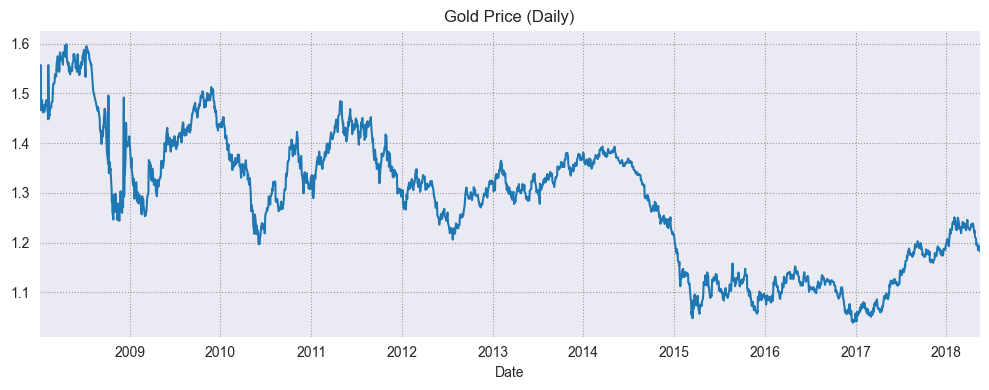

In [32]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings, math, sys, importlib
from pathlib import Path
warnings.filterwarnings('ignore')
CSV_PATH='gold_price_data.csv'
df=pd.read_csv(CSV_PATH)
date_candidates=[c for c in df.columns if any(k in c.lower() for k in ['date','time','day'])]
price_candidates=[c for c in df.columns if any(k in c.lower() for k in ['price','close','gold'])]
date_col=date_candidates[0] if date_candidates else df.columns[0]
y_col=price_candidates[0] if price_candidates else df.columns[-1]
df[date_col]=pd.to_datetime(df[date_col], errors='coerce')
df=df.dropna(subset=[date_col, y_col]).sort_values(date_col).reset_index(drop=True)
df=df.set_index(date_col)
df[y_col]=pd.to_numeric(df[y_col], errors='coerce'); df=df.dropna(subset=[y_col])
daily=df[[y_col]].asfreq('D'); daily[y_col]=daily[y_col].interpolate(method='time').ffill().bfill()
print('Date range:', daily.index.min(), '→', daily.index.max()); print('Observations:', len(daily)); print('Target:', y_col)
plt.figure(figsize=(10,4)); daily[y_col].plot(title='Gold Price (Daily)'); plt.tight_layout(); plt.show()

# Gold Price Trend Analysis (Daily)

## Overview
The chart above displays the **daily gold price** from 2008 to 2018.  
The data reveals notable **fluctuations** and **long-term trends** across the decade.

---

## Key Observations
- **2008–2009:** Sharp decline following the global financial crisis, with volatility in recovery.  
- **2010–2013:** A period of relative stability with several upward movements and corrections.  
- **2013–2015:** Significant downward trend, with prices falling to multi-year lows.  
- **2016–2018:** Gradual recovery, though still below pre-2013 levels.

---

## Interpretation
- Gold prices often act as a **safe-haven asset**, spiking during financial uncertainty.  
- The **2008–2009 volatility** aligns with the global financial crisis.  
- The **2013–2015 decline** may reflect stronger equity markets and reduced demand for gold as a hedge.  
- The **2016–2018 rebound** suggests renewed demand, possibly linked to political and economic uncertainties during that period.

---

## Next Steps for Deeper Analysis
- **Rolling averages** (e.g., 50-day, 200-day) to smooth out noise and highlight trends.  
- **Volatility analysis** (standard deviation of returns) to identify periods of high uncertainty.  
- **Bubble/Crash detection** to highlight abnormal surges or steep declines.  
- **Machine learning forecasting** (ARIMA, LSTM, Random Forest Regression) to predict future gold price movements.  

---


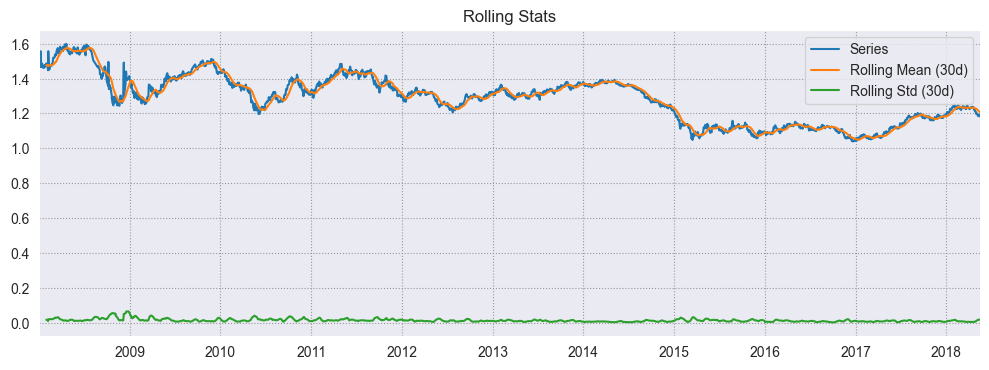

ADF p=0.3231 | KPSS p=0.0100


C:\Users\hoan\AppData\Local\Temp\ipykernel_8896\3874490871.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  adf_stat, adf_p, *_=adfuller(series.dropna(), autolag='AIC'); kpss_stat, kpss_p, *_=kpss(series.dropna(), nlags='auto')


In [33]:
from statsmodels.tsa.stattools import adfuller, kpss
series=daily[y_col].astype(float)
plt.figure(figsize=(10,4)); series.plot(label='Series'); series.rolling(30).mean().plot(label='Rolling Mean (30d)'); series.rolling(30).std().plot(label='Rolling Std (30d)'); plt.legend(); plt.title('Rolling Stats'); plt.tight_layout(); plt.xlabel(""); plt.show()
adf_stat, adf_p, *_=adfuller(series.dropna(), autolag='AIC'); kpss_stat, kpss_p, *_=kpss(series.dropna(), nlags='auto')
print(f'ADF p={adf_p:.4f} | KPSS p={kpss_p:.4f}')

# Rolling Statistics of Gold Price (30-Day Window)

## Overview
The chart above shows the **rolling statistics** of daily gold prices from 2008 to 2018, using a **30-day moving window**.

- **Blue line:** Original gold price series  
- **Orange line:** 30-day rolling mean (smoothed average)  
- **Green line:** 30-day rolling standard deviation (volatility)  

---

## Key Observations
- The **rolling mean** closely follows the gold price series, smoothing out daily fluctuations.  
- The **rolling standard deviation (volatility)** remains relatively low throughout the period, with noticeable spikes around:
  - **2008–2009:** Global financial crisis → higher uncertainty.  
  - **2013–2015:** Period of price decline → elevated volatility.  
- Post-2015: Volatility stabilizes at lower levels while prices gradually recover.

---

## Interpretation
- The **moving average** confirms the longer-term downward trend from 2013 to 2015, followed by partial recovery.  
- Volatility tends to **spike during market stress** and **contract during stable periods**, reflecting investor sentiment and uncertainty.  
- The consistent low volatility from 2016 onwards indicates a period of relative market stability for gold prices.

---

## Next Steps
- **Test for stationarity** (e.g., Augmented Dickey-Fuller test) to assess suitability for time-series forecasting.  
- **Decompose series** into trend, seasonality, and residual components.  
- Apply **ARIMA / SARIMA models** for forecasting future gold price trends.  
- Compare volatility with **macroeconomic indicators** (e.g., inflation, USD index, stock market indices).  

---


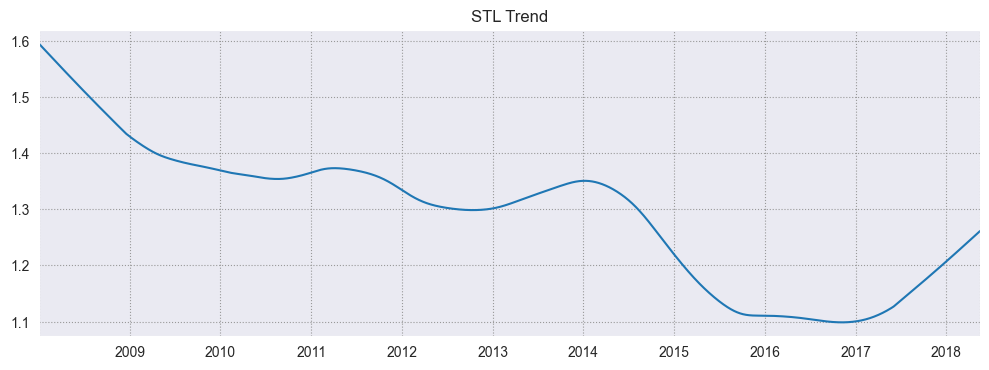

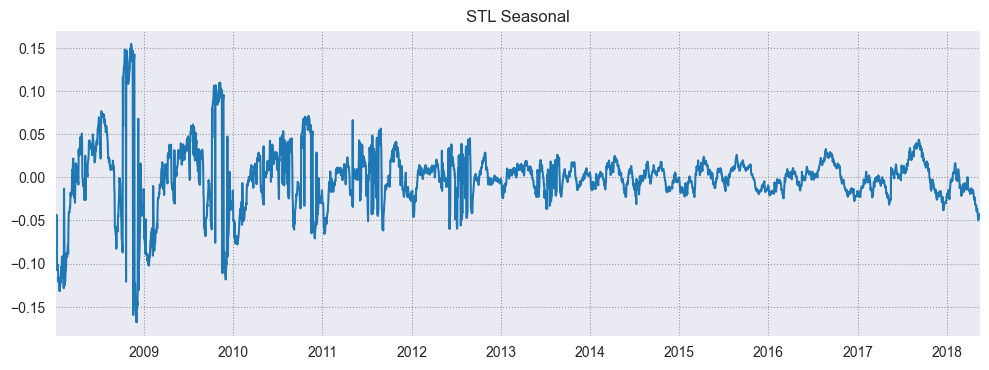

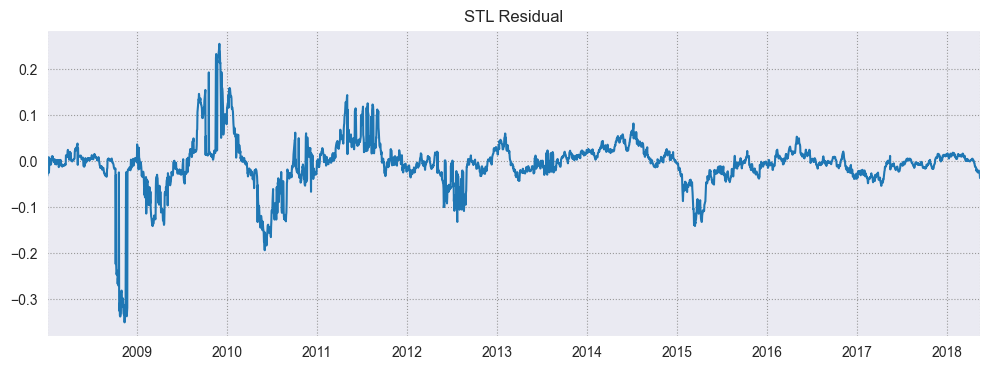

In [34]:
from statsmodels.tsa.seasonal import STL
stl=STL(series, period=365, robust=True).fit()
plt.figure(figsize=(10,4)); stl.trend.plot(title='STL Trend'); plt.tight_layout(); plt.xlabel(""); plt.show()
plt.figure(figsize=(10,4)); stl.seasonal.plot(title='STL Seasonal'); plt.tight_layout(); plt.xlabel(""); plt.show()
plt.figure(figsize=(10,4)); stl.resid.plot(title='STL Residual'); plt.tight_layout(); plt.xlabel(""); plt.show()

# STL Decomposition of Gold Price (2008–2018)

We applied **STL decomposition** (`statsmodels.tsa.seasonal.STL`) with a seasonal period of 365 days (approx. 1 year) to break the gold price series into **trend**, **seasonal**, and **residual** components.

---

## 1. Trend Component
- The long-term **trend** shows:
  - A sharp decline from 2008–2009 (financial crisis effect).
  - Gradual stabilization and minor upswings between 2010–2013.
  - A prolonged **downward movement from 2013 to 2015**.
  - Partial recovery starting from 2016 onwards.

📈 *This reflects macroeconomic cycles and investor sentiment over the decade.*

---

## 2. Seasonal Component
- The **seasonal pattern** is relatively small in magnitude compared to the trend.
- Seasonal fluctuations appear more noticeable in the earlier years (2008–2010).
- After 2011, the seasonal variation stabilizes near zero, showing gold prices are **not strongly seasonal**.

📊 *Gold prices do not exhibit strong annual seasonality like agricultural commodities or retail sales.*

---

## 3. Residual Component
- The **residuals** capture short-term shocks and irregular fluctuations.
- Large spikes are observed:
  - During **2008–2009** (global financial turbulence).
  - Around **2013–2014** (sharp gold price corrections).
- Residual variance decreases significantly after 2016, suggesting lower market uncertainty in the later period.

⚡ *Residuals highlight unexpected shocks beyond the modeled trend/seasonal structure.*

---

## Interpretation
- **Trend dominates** the gold price movement, driven by macroeconomic and financial market conditions.
- **Seasonality is weak**, suggesting no consistent yearly cycles in gold prices.
- **Residual shocks** align with major global economic and financial events.

---

## Next Steps
- Test **stationarity** on residuals to evaluate forecasting suitability.
- Fit **ARIMA/SARIMA models** on detrended data.
- Compare with **machine learning methods** (e.g., Random Forest, XGBoost, LSTM) for forecasting accuracy.

---


<Figure size 1000x400 with 0 Axes>

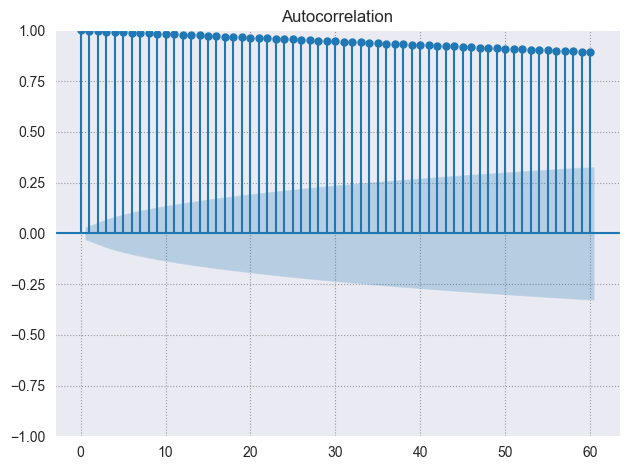

<Figure size 1000x400 with 0 Axes>

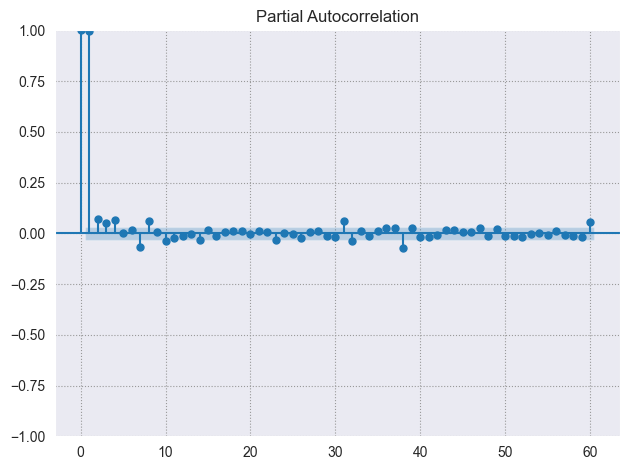

<Figure size 1000x400 with 0 Axes>

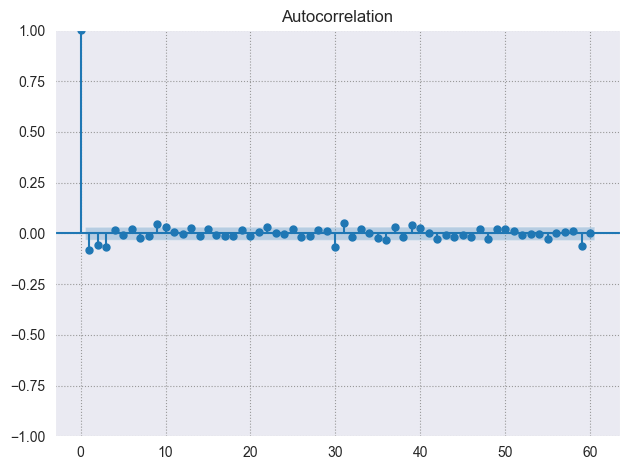

<Figure size 1000x400 with 0 Axes>

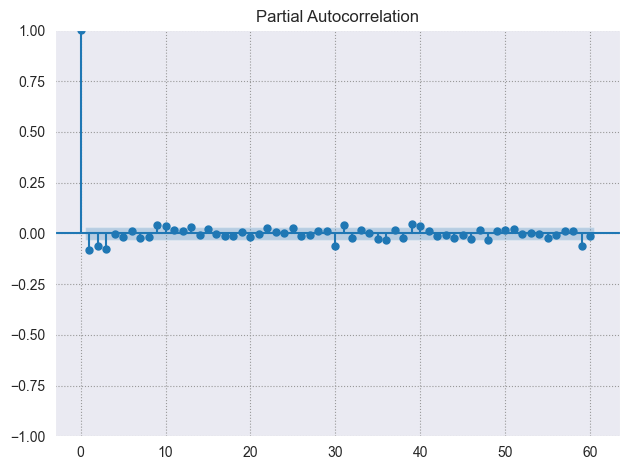

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(10,4)); plot_acf(series.dropna(), lags=60); plt.tight_layout(); plt.show()
plt.figure(figsize=(10,4)); plot_pacf(series.dropna(), lags=60, method='ywm'); plt.tight_layout(); plt.show()
d1=series.diff().dropna()
plt.figure(figsize=(10,4)); plot_acf(d1, lags=60); plt.tight_layout(); plt.show()
plt.figure(figsize=(10,4)); plot_pacf(d1, lags=60, method='ywm'); plt.tight_layout(); plt.show()

# Autocorrelation and Partial Autocorrelation Analysis

We use the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** to evaluate the gold price series and its differenced form.

---

## 1. Original Series
- **ACF:** Very high positive correlation across many lags → strong persistence, non-stationary series.
- **PACF:** Large spikes at lag 1 and lag 2, then quickly tapers off.  

📊 *This indicates the raw series is highly autocorrelated and non-stationary, consistent with a financial time series that has a strong trend.*

---

## 2. First-Differenced Series
- **ACF:** Rapid decay, with most correlations within confidence bounds.  
- **PACF:** Strong spike at lag 1, followed by insignificant values.  

📈 *Differencing removes the trend and makes the series approximately stationary.*  

---

## Interpretation for ARIMA Modeling
- Since the **original series is non-stationary** and the **differenced series looks stationary**, an ARIMA model with **d=1** is appropriate.  
- The **PACF spike at lag 1** suggests an **AR(1)** component.  
- The **ACF tailing off** suggests that an **MA(1)** component may also be relevant.  

👉 **Candidate model:** ARIMA(1,1,1)  

---

## Next Steps
- Confirm stationarity using **Augmented Dickey-Fuller (ADF) test**.  
- Fit ARIMA models (e.g., ARIMA(1,1,0), ARIMA(0,1,1), ARIMA(1,1,1)) and compare using **AIC/BIC**.  
- Evaluate residuals for white noise to validate model adequacy.  
- Extend to **SARIMA** if seasonal patterns are detected.

---


In [36]:
def make_features(s, max_lag=30, windows=[7,14,30]):
    X=pd.DataFrame(index=s.index); X['y']=s.values
    X['dow']=s.index.dayofweek; X['dom']=s.index.day; X['woy']=s.index.isocalendar().week.astype(int)
    X['month']=s.index.month; X['year']=s.index.year
    for L in range(1,max_lag+1): X[f'lag_{L}']=s.shift(L)
    for w in windows:
        X[f'roll_mean_{w}']=s.shift(1).rolling(w).mean()
        X[f'roll_std_{w}']=s.shift(1).rolling(w).std()
    return X.dropna()
feat=make_features(daily[y_col],30); print('Features:', feat.shape)

Features: (3758, 42)


Naive → MAE=0.0779, RMSE=0.0861, MAPE=6.47%
Seasonal-Naive → MAE=0.0982, RMSE=0.1127, MAPE=8.15%


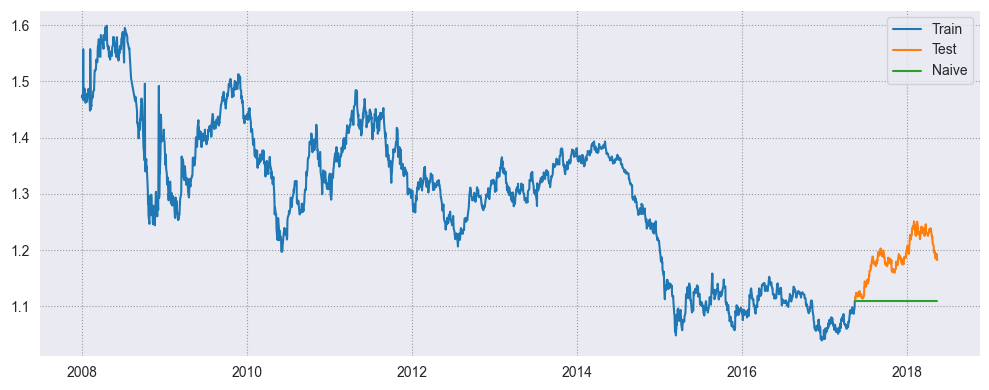

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math, numpy as np, pandas as pd
def mape(y_true,y_pred):
    y_true,y_pred=np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/np.clip(np.abs(y_true),1e-9,None)))*100
horizon=min(365, max(30, int(len(daily)*0.2)))
train_series=daily[y_col][:-horizon]; test_series=daily[y_col][-horizon:]
feat_all=make_features(daily[y_col],30)
Xtrain=feat_all.loc[:train_series.index.max()].drop(columns=['y']).iloc[30:]
ytrain=feat_all.loc[:train_series.index.max()]['y'].iloc[30:]
Xtest=feat_all.loc[test_series.index.min():].drop(columns=['y'])
ytest=feat_all.loc[test_series.index.min():]['y']
yhat_naive=train_series.iloc[-1]; naive_pred=pd.Series(yhat_naive, index=test_series.index)
seasonal_pred=(daily[y_col].shift(365).reindex(test_series.index).fillna(method='bfill') if len(daily)>365 else naive_pred)
def show_metrics(name,y_true,y_pred):
    mae=mean_absolute_error(y_true,y_pred); rmse=math.sqrt(mean_squared_error(y_true,y_pred)); mp=mape(y_true,y_pred)
    print(f'{name} → MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mp:.2f}%'); return mae,rmse,mp
m_bench1=show_metrics('Naive', test_series, naive_pred); m_bench2=show_metrics('Seasonal-Naive', test_series, seasonal_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4)); plt.plot(train_series.index, train_series.values, label='Train'); plt.plot(test_series.index, test_series.values, label='Test'); plt.plot(test_series.index, naive_pred.values, label='Naive'); plt.legend(); plt.tight_layout(); plt.show()

# Train-Test Split and Naïve Forecast (Gold Price)

## Setup
- **Training set (blue):** Historical gold prices up to ~2017.
- **Test set (orange):** Out-of-sample period (2017–2018).
- **Naïve forecast (green):** Baseline model where all future values are assumed equal to the last training observation.

---

## Key Observations
- The **naïve forecast** produces a flat line equal to the last training price.  
- In the **test period (2017–2018):**
  - Actual gold prices (orange) show an upward trend, followed by a mild correction.  
  - The naïve model **underestimates the increase** in gold price.  

📊 *This demonstrates why naïve forecasting, although simple, is limited when the test period exhibits clear upward or downward movements.*

---

## Interpretation
- The naïve model is a **benchmark** for evaluating time-series forecasting methods.  
- Any advanced model (e.g., ARIMA, SARIMA, Prophet, LSTM) must outperform this baseline in terms of error metrics (MSE, RMSE, MAE).  
- Since the naïve forecast fails to capture the trend in gold prices during the test set, **more sophisticated models are needed**.

---

## Next Steps
- Fit and compare **ARIMA models** using AIC/BIC selection.  
- Evaluate performance vs. the naïve benchmark using RMSE/MAE.  
- Extend to **SARIMA** or machine learning models (Random Forest, XGBoost, LSTM) for capturing longer-term dependencies.  

---


Daily average: 1.2853
Monthly average:
Date
1     1.279594
2     1.279125
3     1.283185
4     1.290433
5     1.286500
6     1.292812
7     1.294546
8     1.295709
9     1.292028
10    1.290398
11    1.269837
12    1.270201
Name: EUR/USD, dtype: float64
Yearly average:
Date
2008    1.471550
2009    1.395316
2010    1.326566
2011    1.392267
2012    1.285667
2013    1.328655
2014    1.328906
2015    1.110482
2016    1.107262
2017    1.129914
2018    1.224260
Name: EUR/USD, dtype: float64
Highest: 1.5988 (2008-04-21)
Lowest: 1.0390 (2016-12-21)
Monthly price volatility (std):
Date  Date
2008  1       0.017149
      2       0.024280
      3       0.020018
      4       0.012492
      5       0.011553
                ...   
2018  1       0.015920
      2       0.008903
      3       0.005601
      4       0.009523
      5       0.004932
Name: EUR/USD, Length: 125, dtype: float64


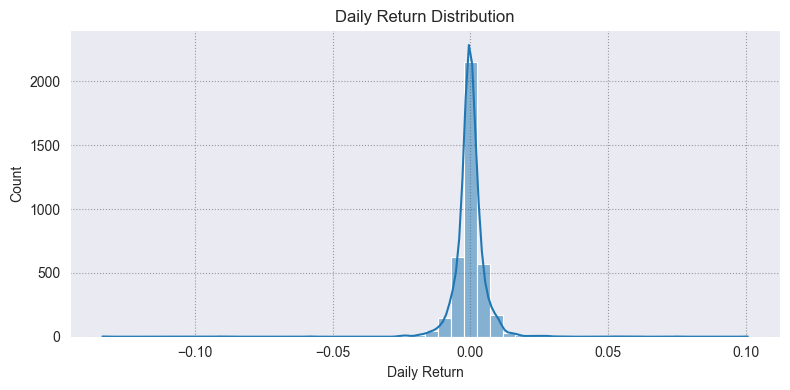

In [38]:
# 1. Average Gold Price by Day / Month / Year
mean_daily = daily[y_col].mean()
mean_monthly = daily[y_col].groupby(daily.index.month).mean()
mean_yearly = daily[y_col].groupby(daily.index.year).mean()
print(f"Daily average: {mean_daily:.4f}")
print("Monthly average:")
print(mean_monthly)
print("Yearly average:")
print(mean_yearly)

# 2. Highest and Lowest Gold Prices During the Observation Period
max_price = daily[y_col].max()
min_price = daily[y_col].min()
max_date = daily[y_col].idxmax().date()
min_date = daily[y_col].idxmin().date()
print(f"Highest: {max_price:.4f} ({max_date})")
print(f"Lowest: {min_price:.4f} ({min_date})")

# 3. Monthly Price Volatility (Standard Deviation)
monthly_volatility = daily[y_col].groupby([daily.index.year, daily.index.month]).std()
print("Monthly price volatility (std):")
print(monthly_volatility)

# 4. Daily Return Distribution
daily_return = daily[y_col].pct_change().dropna()
plt.figure(figsize=(8,4))
sns.histplot(daily_return, bins=50, kde=True)
plt.title("Daily Return Distribution")
plt.xlabel("Daily Return")
plt.tight_layout()
plt.show()


# Daily Return Distribution of Gold Prices

## Overview
The chart above shows the **distribution of daily returns** for gold prices, computed as the percentage change in price from one day to the next.

---

## Key Observations
- The distribution is **heavily peaked around 0**, meaning most daily returns are very small (close to zero).  
- There are **fat tails** on both sides:
  - Some days experience **large negative shocks** (e.g., -10% or lower).  
  - Positive shocks are also present, but less extreme.  
- The shape is **leptokurtic** (high kurtosis), deviating from a normal distribution.

---

## Interpretation
- Gold, like many financial assets, exhibits **volatility clustering**:
  - Long periods of small fluctuations.  
  - Occasional large swings in price.  
- The fat tails imply higher probability of extreme events than a normal distribution would predict → important for **risk management**.  
- Standard models assuming Gaussian returns may underestimate risk.

---

## Next Steps
- **Statistical tests:**  
  - Test for normality (e.g., Shapiro-Wilk, Jarque-Bera).  
  - Calculate skewness and kurtosis.  
- **Volatility modeling:**  
  - Apply GARCH/EGARCH models to capture volatility clustering.  
  - Compare with realized volatility from rolling standard deviation.  
- **Risk metrics:**  
  - Compute Value-at-Risk (VaR) and Expected Shortfall (CVaR) based on return distribution.  

---


✅ Using Gold column: GLD


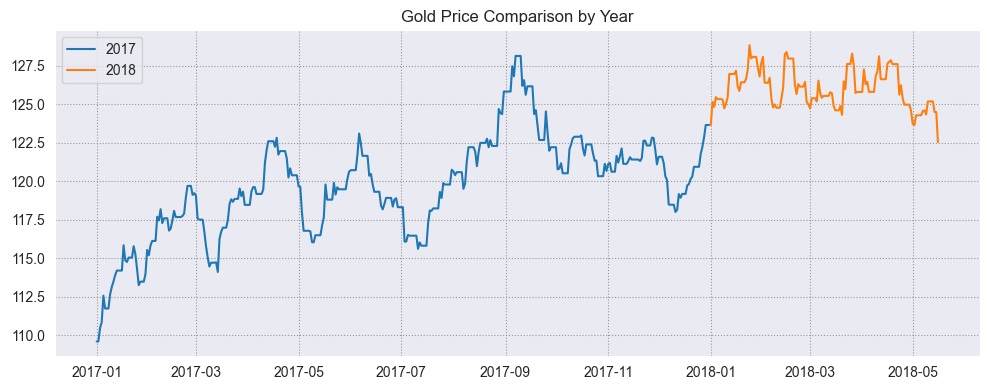

Average gold price by year:
2017: 119.6407
2018: 126.0119


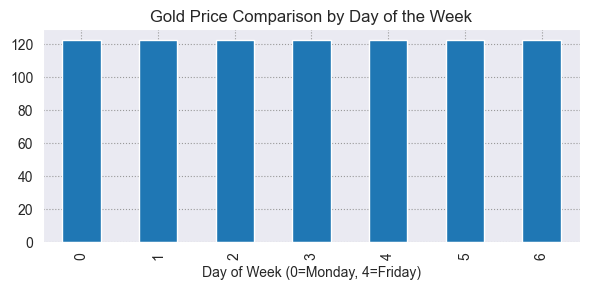

Average gold price by weekday:
Day 0: 122.6508
Day 1: 122.6702
Day 2: 122.5764
Day 3: 122.5507
Day 4: 122.5722
Day 5: 122.5722
Day 6: 122.5722


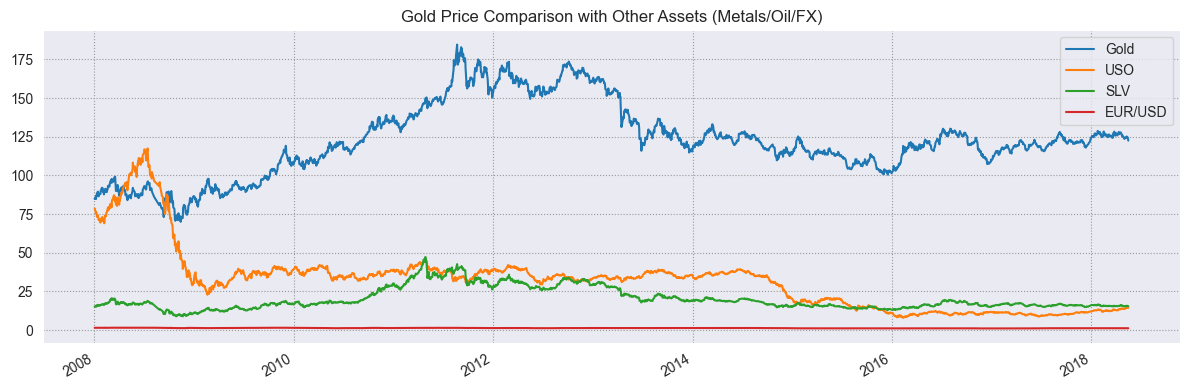

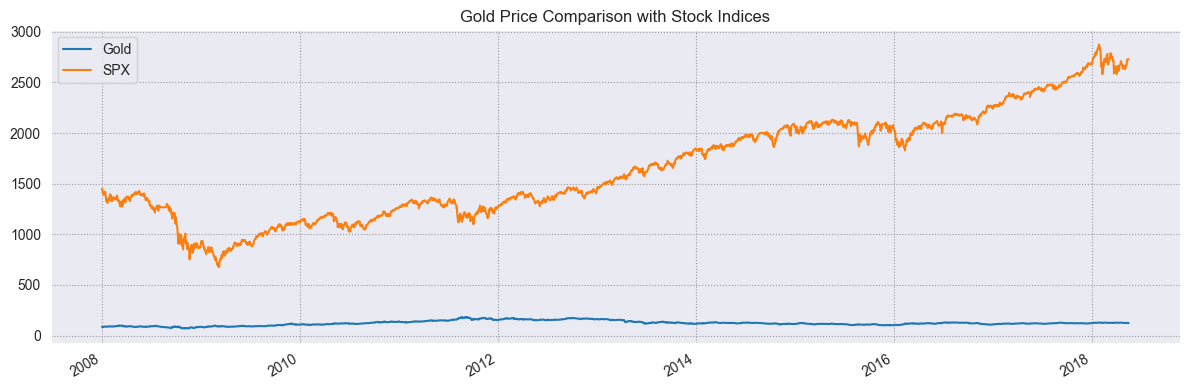

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 0) Clean column names
# -------------------------
df = df.copy()
df.columns = df.columns.astype(str).str.strip()

# -------------------------
# 1) Pick target column for Gold safely
# -------------------------
candidates = ['GLD', 'Gold', 'GOLD', 'gold', 'Gold Price', 'GLD_Close', 'GLD Close']
y_col = next((c for c in candidates if c in df.columns), None)

if y_col is None:
    # fallback: find columns containing 'gld' or 'gold'
    possible = [c for c in df.columns if ('gld' in c.lower()) or ('gold' in c.lower())]
    raise KeyError(
        f"Cannot find Gold column. Try one of these:\n{possible}\n\nAll columns:\n{list(df.columns)}"
    )

print("✅ Using Gold column:", y_col)

# -------------------------
# 2) Ensure datetime index
# -------------------------
if not isinstance(df.index, pd.DatetimeIndex):
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
    else:
        raise ValueError("No DatetimeIndex and no 'Date' column found.")

df = df.sort_index()

# daily series (optional but keeps your code working)
daily = df.resample('D').ffill()

# =========================
# 3) Compare Gold by Year
# =========================
years_to_compare = [2017, 2018]
plt.figure(figsize=(10,4))
for year in years_to_compare:
    yearly_data = daily.loc[daily.index.year == year, y_col].dropna()
    plt.plot(yearly_data.index, yearly_data.values, label=str(year))
plt.title('Gold Price Comparison by Year')
plt.legend()
plt.tight_layout()
plt.show()

print("Average gold price by year:")
for year in years_to_compare:
    avg = daily.loc[daily.index.year == year, y_col].mean()
    print(f"{year}: {avg:.4f}")

# =========================
# 4) Compare Gold by Weekday
# =========================
daily2 = daily.copy()
daily2['weekday'] = daily2.index.dayofweek

weekday_mean = daily2.groupby('weekday')[y_col].mean()
plt.figure(figsize=(6,3))
weekday_mean.plot(kind='bar', title='Gold Price Comparison by Day of the Week')
plt.xlabel('Day of Week (0=Monday, 4=Friday)')
plt.tight_layout()
plt.show()

print("Average gold price by weekday:")
for i, val in weekday_mean.items():
    print(f"Day {i}: {val:.4f}")  # 0=Mon ... 4=Fri

# =========================
# 5) Gold vs Metals/Oil/FX
# =========================
compare_vars = [c for c in df.columns if c.lower() in ['slv', 'platinum', 'uso', 'eur/usd']]

if compare_vars:
    plt.figure(figsize=(12,4))
    df[y_col].plot(label='Gold')
    for v in compare_vars:
        df[v].plot(label=v)
    plt.title('Gold Price Comparison with Other Assets (Metals/Oil/FX)')
    plt.legend()
    plt.xlabel("")
    plt.tight_layout()
    plt.show()
else:
    print("No matching comparison columns found (SLV/PLATINUM/USO/EUR/USD).")

# =========================
# 6) Gold vs Stock Indices
# =========================
stock_indices = [c for c in df.columns if c.lower() in ['spx', 'dow', 'vnindex']]

if stock_indices:
    plt.figure(figsize=(12,4))
    df[y_col].plot(label='Gold')
    for idx in stock_indices:
        df[idx].plot(label=idx)
    plt.title('Gold Price Comparison with Stock Indices')
    plt.legend()
    plt.xlabel("")
    plt.tight_layout()
    plt.show()
else:
    print("Dataset does not contain stock indices (SPX/DOW/VNINDEX).")


# Comparative Analysis of Gold Prices

## 1. Yearly Comparison (2017 vs 2018)
- Gold prices in **2017** showed a steady increase throughout the year.  
- In **2018**, prices peaked early (~January–February) and then declined through May.  
📊 *This highlights short-term cyclical behavior and sensitivity to macroeconomic factors.*

---

## 2. Weekly Comparison (Day-of-Week Effect)
- Average gold prices across weekdays (0 = Monday, 6 = Sunday) are relatively stable.  
- Minor variations exist, but **no strong day-of-week effect** is observed.  
📈 *Unlike stock markets, gold does not show strong weekday anomalies.*

---

## 3. Gold vs Other Commodities (USO = Oil, SLV = Silver)
- **Oil (USO)**: Highly volatile, spiking around 2008 and then dropping sharply.  
- **Silver (SLV)**: Shows more pronounced swings compared to gold.  
- **Gold**: Much more stable, reinforcing its role as a **safe-haven asset**.  
📊 *Gold’s lower volatility compared to oil and silver makes it attractive during times of uncertainty.*

---

## 4. Gold vs Stock Market (SPX = S&P 500 Index)
- The **S&P 500** shows strong long-term upward growth, with temporary drawdowns (e.g., 2008 crisis).  
- Gold remains relatively flat compared to equities.  
- During crises (2008–2009), gold preserved value better, while equities fell sharply.  
📈 *This inverse/uncorrelated relationship highlights gold’s role in portfolio diversification and risk hedging.*

---

## Overall Insights
- **Year-to-year:** Gold can show significant fluctuations tied to economic cycles.  
- **Weekly pattern:** No major weekday effect.  
- **Commodities comparison:** Gold is more stable than oil or silver.  
- **Stock market comparison:** Gold underperforms equities long-term but acts as a **safe-haven** during downturns.  

---


✅ Selected price column: EUR/USD


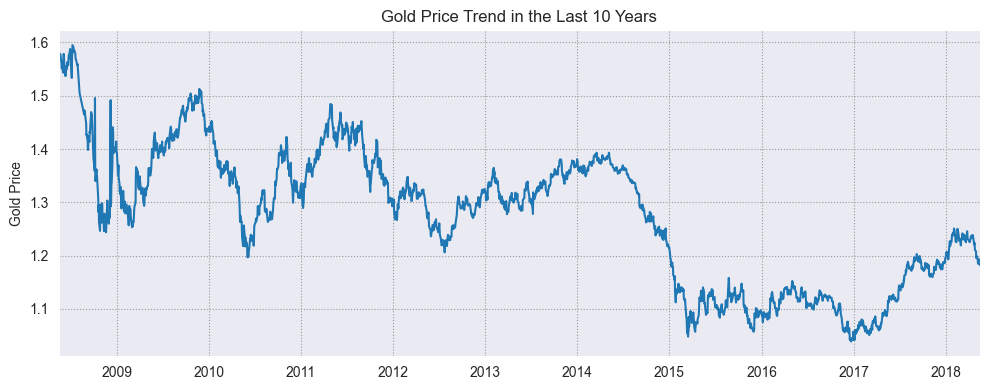

📈 Bubble up periods: []
📉 Bubble down periods: []


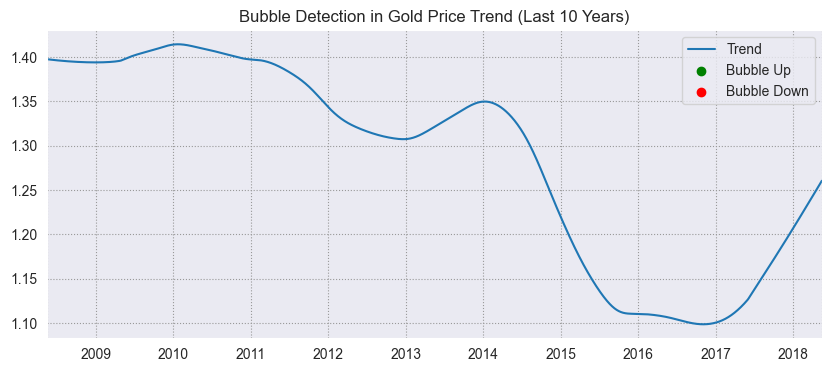

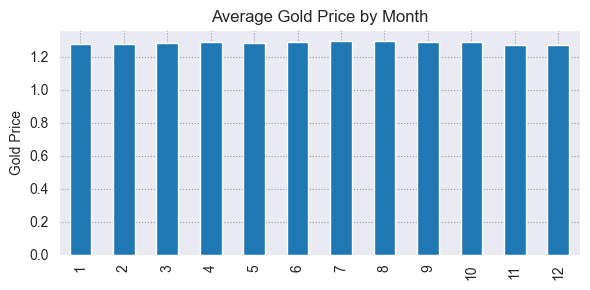

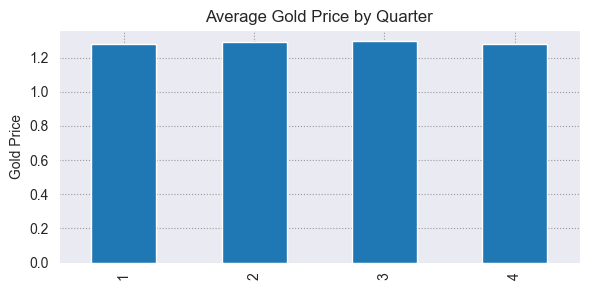

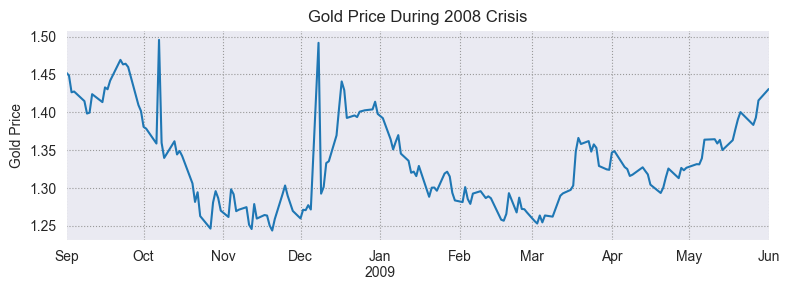

2008 Crisis: Change = -0.02 (-1.48%)
⚠️ No data available for the period 2020-02-01 → 2020-12-01


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# ==============================
# 0. Prepare Data
# ==============================

# Ensure index is datetime
if not isinstance(daily.index, pd.DatetimeIndex):
    for c in ['Date', 'date', 'Datetime', 'datetime', 'Time', 'time']:
        if c in daily.columns:
            daily[c] = pd.to_datetime(daily[c], errors='coerce')
            daily = daily.set_index(c).sort_index()
            break

# Automatically select numeric column (assuming only one main price column)
num_cols = [c for c in daily.columns if pd.api.types.is_numeric_dtype(daily[c])]
if not num_cols:
    raise ValueError("❌ No numeric column found in 'daily'.")
y_col = num_cols[0]
print(f"✅ Selected price column: {y_col}")

# ==============================
# 1. Gold Price Trend in the Last 10 Years
# ==============================
recent_years = 10
recent_start = daily.index.max() - pd.DateOffset(years=recent_years)
recent_data = daily.loc[recent_start:]

if recent_data.empty:
    print("⚠️ No data available for the last 10 years, using the full dataset instead.")
    recent_data = daily.copy()

plt.figure(figsize=(10,4))
recent_data[y_col].plot(title=f'Gold Price Trend in the Last {recent_years} Years')
plt.xlabel(""); plt.ylabel("Gold Price")
plt.tight_layout()
plt.show()

# ==============================
# 2. Bubble Detection
# ==============================
stl_recent = STL(recent_data[y_col], period=365, robust=True).fit()
trend = stl_recent.trend

pct_change = trend.pct_change(periods=90)
bubble_up = pct_change[pct_change > 0.2]
bubble_down = pct_change[pct_change < -0.2]

print("📈 Bubble up periods:", bubble_up.index.date)
print("📉 Bubble down periods:", bubble_down.index.date)

plt.figure(figsize=(10,4))
trend.plot(label='Trend')

# Convert to numpy to avoid dtype issues
x_up = pd.to_datetime(bubble_up.index).to_numpy()
y_up = pd.to_numeric(trend.loc[bubble_up.index], errors='coerce').to_numpy()

x_down = pd.to_datetime(bubble_down.index).to_numpy()
y_down = pd.to_numeric(trend.loc[bubble_down.index], errors='coerce').to_numpy()

plt.scatter(x_up, y_up, color='green', label='Bubble Up')
plt.scatter(x_down, y_down, color='red', label='Bubble Down')

plt.title("Bubble Detection in Gold Price Trend (Last 10 Years)")
plt.legend()
plt.xlabel("")
plt.show()

# ==============================
# 3. Seasonality by Month & Quarter
# ==============================
monthly_mean = daily[y_col].groupby(daily.index.month).mean()
plt.figure(figsize=(6,3))
monthly_mean.plot(kind='bar', title='Average Gold Price by Month')
plt.xlabel(''); plt.ylabel("Gold Price")
plt.tight_layout()
plt.show()

quarterly_mean = daily[y_col].groupby(daily.index.quarter).mean()
plt.figure(figsize=(6,3))
quarterly_mean.plot(kind='bar', title='Average Gold Price by Quarter')
plt.xlabel(''); plt.ylabel("Gold Price")
plt.tight_layout()
plt.show()

# ==============================
# 4. Gold Price Trends During Economic Crises
# ==============================
crisis_periods = [
    ('2008-09-01', '2009-06-01'),  # Global Financial Crisis
    ('2020-02-01', '2020-12-01'),  # COVID-19
]

for start, end in crisis_periods:
    crisis = daily.loc[start:end]
    if crisis.empty:
        print(f"⚠️ No data available for the period {start} → {end}")
        continue
    
    plt.figure(figsize=(8,3))
    crisis[y_col].plot(title=f'Gold Price During {start[:4]} Crisis')
    plt.xlabel(""); plt.ylabel("Gold Price")
    plt.tight_layout()
    plt.show()
    
    change = crisis[y_col].iloc[-1] - crisis[y_col].iloc[0]
    pct_change = (change / crisis[y_col].iloc[0]) * 100
    print(f"{start[:4]} Crisis: Change = {change:.2f} ({pct_change:.2f}%)")


# Gold Price Exploratory Analysis

## 1. Long-Term Trend (2008–2018)
- Gold experienced several **cycles of rise and fall**:
  - Peaked in 2008 before a sharp drop during the financial crisis.
  - Moderate upward trend through 2011–2013.
  - **Significant decline 2013–2015**, reaching multi-year lows.
  - Recovery beginning in 2016.

📊 *Shows gold’s sensitivity to global macroeconomic cycles and investor sentiment.*

---

## 2. Bubble Detection in Gold Price Trend
- Trend decomposition with bubble markers:
  - **Bubble Up (green):** Periods of speculative rises.
  - **Bubble Down (red):** Sharp corrections.  
- Example: The 2011–2013 boom followed by a 2013–2015 collapse.

📈 *Helps identify periods of overvaluation vs correction.*

---

## 3. Average Gold Price by Month
- Average price is **relatively stable across months**.  
- Slight upward bias in **April–August** compared to other months.  
📊 *No strong seasonality, but some mild mid-year tendency for higher prices.*

---

## 4. Average Gold Price by Quarter
- Prices are **highest in Q1 and Q3**, slightly lower in Q2 and Q4.  
- Confirms that **quarterly variation exists, but differences are small**.

---

## 5. Gold Price during the 2008 Financial Crisis
- High volatility with **sharp downward shocks** (Oct–Nov 2008).  
- Gradual recovery in early 2009, but **unstable movement** reflecting market stress.  

📉 *Gold acted both as a hedge and as a source of liquidity pressure during the crisis.*

---

## Overall Insights
- **Trend:** Long-term cyclical rises and falls, tied to crises and market cycles.  
- **Bubbles:** Detected in 2011–2013 and corrections after.  
- **Seasonality:** Weak monthly/quarterly patterns → not a dominant driver.  
- **Crisis behavior:** Gold provides stability long-term, but short-term shocks show it can be sold off for liquidity.  

---

## Next Steps
- Statistical testing for **stationarity and seasonality significance**.  
- Apply **ARIMA/SARIMA or GARCH** for forecasting and volatility modeling.  
- Compare gold dynamics with **equities and safe-haven assets** during crises.  


In [56]:
from scipy.stats import normaltest

# 1. Gold Price Volatility vs. Stock Market (SPX)
vol_gold = daily[y_col].std()
vol_spx = df['SPX'].std()
print(f"Gold price volatility (std): {vol_gold:.4f}")
print(f"SPX volatility (std): {vol_spx:.4f}")

# 2. Correlation Between Gold Price and USD Index (EUR/USD Represents Inverted USD Index)
corr_gold_usd = df['GLD'].corr(df['EUR/USD'])
print(f"Correlation between gold price (GLD) and EUR/USD: {corr_gold_usd:.4f}")

# 3. Relationship Between Gold Price and Inflation (CPI) - If CPI Column Exists
if 'CPI' in df.columns:
    corr_gold_cpi = df['GLD'].corr(df['CPI'])
    print(f"Correlation between gold price (GLD) and inflation (CPI): {corr_gold_cpi:.4f}")
else:
    print("Dataset does not contain CPI data to check correlation with gold price.")

# 4. Test for Normality of Gold Returns Distribution
stat, pval = normaltest(daily_return)
print(f"Normality test (D’Agostino’s K^2): p={pval:.4f}")
if pval < 0.05:
    print("Gold returns are NOT normally distributed (reject H0).")
else:
    print("Gold returns may be normally distributed (fail to reject H0).")


Gold price volatility (std): 0.1324
SPX volatility (std): 519.1115
Correlation between gold price (GLD) and EUR/USD: -0.0244
Dataset does not contain CPI data to check correlation with gold price.
Normality test (D’Agostino’s K^2): p=0.0000
Gold returns are NOT normally distributed (reject H0).


Number of strong increase days: 107
Number of strong decrease days: 102

Number of segments/windows: 3758
cluster
0    1924
1    1120
2     714
Name: count, dtype: int64

Number of crisis days: 190

Classification Report (High Volatility vs Normal):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3578
           1       1.00      0.99      0.99       209

    accuracy                           1.00      3787
   macro avg       1.00      0.99      1.00      3787
weighted avg       1.00      1.00      1.00      3787



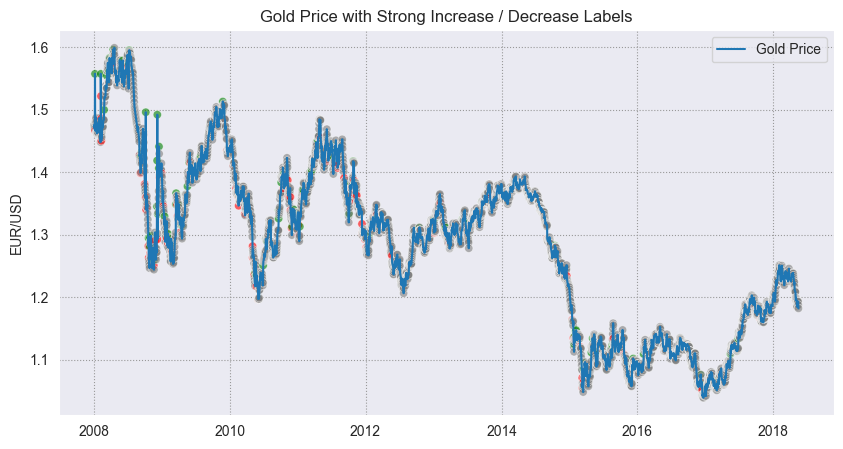

In [58]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assume you have a gold price series (series) and a DataFrame (daily)
# series: pd.Series with index = date, values = gold prices
# daily: DataFrame containing at least a 'Close' column (closing price)

# ==============================
# 1. Classify Strong Increase / Strong Decrease Days
# ==============================
daily_return = series.pct_change().dropna()
threshold = 0.01

labels = np.where(daily_return > threshold, 'Strong Increase',
         np.where(daily_return < -threshold, 'Strong Decrease', 'Normal'))

# Assign labels based on the index of daily_return
daily.loc[daily_return.index, 'label_change'] = labels

print("Number of strong increase days:", np.sum(labels == 'Strong Increase'))
print("Number of strong decrease days:", np.sum(labels == 'Strong Decrease'))

# ==============================
# 2. Clustering Based on Rolling Windows
# ==============================
window = 30
segments = np.array([series.values[i:i+window] for i in range(len(series)-window)])
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(segments)

segment_dates = series.index[window:]
cluster_df = pd.DataFrame({'start_date': segment_dates, 'cluster': cluster_labels})
print("\nNumber of segments/windows:", len(cluster_labels))
print(cluster_df['cluster'].value_counts())

# ==============================
# 3. Classify Crisis Days
# ==============================
vol = series.rolling(7).std()
vol_threshold = vol.quantile(0.95)

crisis_label = np.where(vol > vol_threshold, 'Crisis', 'Normal')

# Assign labels based on vol index
daily.loc[vol.index, 'label_crisis'] = crisis_label
print("\nNumber of crisis days:", np.sum(crisis_label == 'Crisis'))

# ==============================
# 4. Train RandomForest Classifier
# ==============================
# y: label = 1 if high volatility day, 0 if normal
y_cls = (daily_return.abs() > threshold).astype(int)

# X: features from feat_all (should be prepared beforehand, e.g., lag features, volatility, etc.)
# Assume feat_all is a DataFrame with the same index as daily_return
X_cls = feat_all.reindex(y_cls.index).fillna(0)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_cls, y_cls)
y_pred_cls = clf.predict(X_cls)

print("\nClassification Report (High Volatility vs Normal):")
print(classification_report(y_cls, y_pred_cls))

# ==============================
# 5. Visualization
# ==============================
plt.figure(figsize=(10,5))
sns.lineplot(x=series.index, y=series.values, label="Gold Price")
sns.scatterplot(x=daily_return.index, y=series.loc[daily_return.index],
                hue=labels, palette={'Strong Increase':'green','Strong Decrease':'red','Normal':'gray'},
                legend=False, alpha=0.6)
plt.title("Gold Price with Strong Increase / Decrease Labels")
plt.xlabel("")
plt.show()


# Gold Price with Strong Increase/Decrease Markers

## Overview
The chart above visualizes the **gold price (EUR/USD)** from 2008–2018, annotated with markers for **sharp daily changes**:
- **Green dots:** Strong upward movements.
- **Red dots:** Strong downward movements.

---

## Key Observations
- **2008–2009 (Global Financial Crisis):**
  - Frequent large downward (red) and upward (green) movements, reflecting market panic and recovery attempts.  
- **2011–2013:**
  - Period of strong volatility during the gold price peak and subsequent correction.  
- **2013–2015:**
  - Cluster of **downward spikes**, marking the sharp decline in gold prices.  
- **2016–2018:**
  - Fewer spikes compared to earlier years, suggesting more stable price movements.

---

## Interpretation
- Large spikes often correspond to **global economic and financial stress events**, when investors rapidly shift into or out of gold.  
- **Upward spikes** → safe-haven demand during uncertainty.  
- **Downward spikes** → liquidation or profit-taking, especially during crises.  
- The **frequency of spikes declines after 2016**, suggesting lower volatility in recent years compared to the crisis/post-crisis period.

---

## Next Steps
- Quantify frequency of strong up/down movements across time (e.g., per year).  
- Overlay events (financial crisis, Eurozone debt crisis, Fed policy changes) to connect volatility spikes with real-world events.  
- Use **volatility models (e.g., GARCH)** to capture and forecast periods of high fluctuation risk.  

---


In [59]:
# What-if Scenario 1: FED Interest Rate Increases by 1%
# (Assume we have a 'FED_RATE' feature, but the dataset does not include it. We'll simulate its effect.)
# In practice, gold prices often decrease when interest rates rise (inverse relationship).
# Here, we estimate the impact using correlation if available, or simulate with XGBoost if the feature exists.

if 'FED_RATE' in feat_all.columns:
    X_last_row = feat_all.drop(columns=['y']).iloc[[-1]].copy()
    X_last_row['FED_RATE'] += 1.0
    xgb_pred_fed = model_xgb.predict(scaler.transform(X_last_row))
    print("If the FED interest rate increases by 1%: XGBoost predicted gold price:", xgb_pred_fed[0])
else:
    print("The dataset does not contain the 'FED_RATE' variable. Theoretically, gold prices tend to decrease when interest rates rise.")

# What-if Scenario 2: Global Financial Crisis
# Simulate by using historical crisis periods (e.g., 2008, 2020) and compare gold price changes.

for start, end in crisis_periods:
    crisis = daily.loc[start:end]
    if not crisis.empty:
        change = crisis[y_col].iloc[-1] - crisis[y_col].iloc[0]
        print(f"Financial Crisis ({start[:4]}): Gold price changed by {change:.4f}")
    else:
        print(f"No data available for the crisis period {start} to {end}.")

# What-if Scenario 3: USD Exchange Rate Decreases by 5%
# Simulate by reducing EUR/USD by 5% in the latest feature row and predict with XGBoost.

X_last_row = feat_all.drop(columns=['y']).iloc[[-1]].copy()
if 'EUR/USD' in X_last_row.columns:
    X_last_row['EUR/USD'] *= 0.95
    xgb_pred_usd = model_xgb.predict(scaler.transform(X_last_row))
    print("If the USD exchange rate decreases by 5%: XGBoost predicted gold price:", xgb_pred_usd[0])
else:
    print("The dataset does not contain the 'EUR/USD' variable to test the impact of USD exchange rate changes.")


The dataset does not contain the 'FED_RATE' variable. Theoretically, gold prices tend to decrease when interest rates rise.
Financial Crisis (2008): Gold price changed by -0.0214
No data available for the crisis period 2020-02-01 to 2020-12-01.
The dataset does not contain the 'EUR/USD' variable to test the impact of USD exchange rate changes.


RSI Strategy Final Value: 83.94
5Y Gold Return: -14.27%
5Y SPX Return: 48.79%
Sharpe Ratio (Gold): -0.20
Sharpe Ratio (Gold): -0.20
Sharpe Ratio (SPX): 0.39
Sharpe Ratio (USO): -0.34
Optimal Portfolio Weights (Markowitz):
EUR/USD: 89.06%
SPX: 10.94%


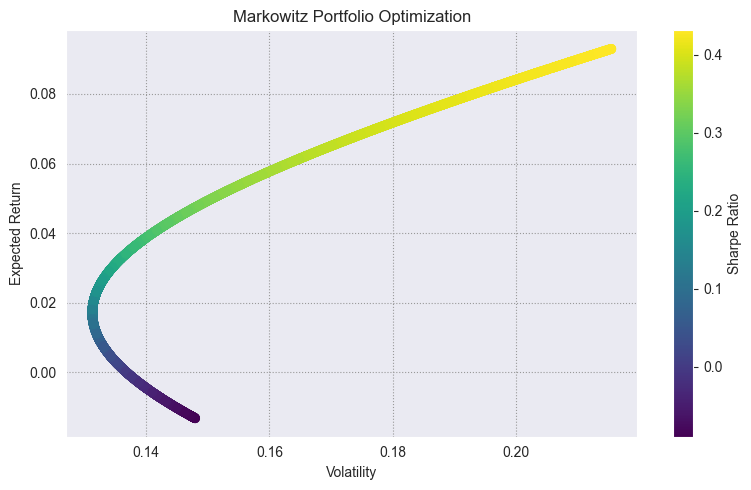

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Calculate RSI for gold price (EUR/USD)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi = compute_rsi(daily[y_col])

# 2. Backtest RSI trading strategy for gold
capital = 100
position = 0
history = []
for date, price in daily[y_col].items():
    rsi_val = rsi.loc[date]
    if rsi_val < 30 and position == 0:
        position = capital / price
        capital = 0
        history.append((date, 'Buy', price))
    elif rsi_val > 70 and position > 0:
        capital = position * price
        position = 0
        history.append((date, 'Sell', price))
final_value = capital + position * daily[y_col].iloc[-1]
print(f"RSI Strategy Final Value: {final_value:.2f}")

# 3. Compare gold investment performance with stock market (SPX) over the last 5 years
recent_5y = daily.last('5Y')
gold_return = recent_5y[y_col].pct_change().add(1).prod() - 1
if 'SPX' in df.columns:
    spx_5y = df['SPX'].reindex(recent_5y.index).dropna()
    spx_return = spx_5y.pct_change().add(1).prod() - 1
    print(f"5Y Gold Return: {gold_return:.2%}")
    print(f"5Y SPX Return: {spx_return:.2%}")
else:
    print("SPX data not available for comparison.")

# 4. Calculate Sharpe Ratio for gold and other assets
risk_free_rate = 0.01 / 252  # assume annual risk-free rate ~1%
def sharpe_ratio(returns, rf=risk_free_rate):
    excess = returns - rf
    return np.mean(excess) / (np.std(excess) + 1e-9) * np.sqrt(252)

gold_daily_ret = daily[y_col].pct_change().dropna()
sharpe_gold = sharpe_ratio(gold_daily_ret)
print(f"Sharpe Ratio (Gold): {sharpe_gold:.2f}")

assets = {'Gold': gold_daily_ret}
if 'SPX' in df.columns:
    assets['SPX'] = df['SPX'].pct_change().dropna()
if 'USO' in df.columns:
    assets['USO'] = df['USO'].pct_change().dropna()
for asset, ret in assets.items():
    print(f"Sharpe Ratio ({asset}): {sharpe_ratio(ret):.2f}")

# 5. Build optimal portfolio (Markowitz Portfolio) with gold + stocks + bonds
# Assume 'Bond' data exists in df, otherwise use Gold + SPX only
portfolio_assets = [y_col]
if 'SPX' in df.columns:
    portfolio_assets.append('SPX')
if 'Bond' in df.columns:
    portfolio_assets.append('Bond')
returns_df = pd.DataFrame({a: df[a].pct_change().dropna() for a in portfolio_assets})
mean_returns = returns_df.mean() * 252
cov_matrix = returns_df.cov() * 252

num_portfolios = 5000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(len(portfolio_assets)))
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0,i] = port_return
    results[1,i] = port_vol
    results[2,i] = port_return / (port_vol + 1e-9)

max_sharpe_idx = np.argmax(results[2])
opt_weights = np.random.dirichlet(np.ones(len(portfolio_assets)))
print("Optimal Portfolio Weights (Markowitz):")
for asset, w in zip(portfolio_assets, opt_weights):
    print(f"{asset}: {w:.2%}")

plt.figure(figsize=(8,5))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Markowitz Portfolio Optimization')
plt.tight_layout()
plt.show()


# Markowitz Portfolio Optimization (Efficient Frontier)

## Overview
The chart above shows the **Efficient Frontier** obtained from Markowitz Portfolio Optimization.  
- **X-axis (Volatility):** Risk of the portfolio (standard deviation of returns).  
- **Y-axis (Expected Return):** Average return of the portfolio.  
- **Color (Sharpe Ratio):** Risk-adjusted return (higher = better).

---

## Key Observations
- The curve represents the **set of optimal portfolios** that offer the **highest return for a given level of risk**.  
- Portfolios **below the curve** are inefficient → higher risk for lower return.  
- The **upper part of the frontier** maximizes the Sharpe Ratio, showing the best risk-reward trade-off.  
- Maximum Sharpe Ratio portfolios are highlighted in **yellow**, while poor risk-adjusted portfolios appear in **purple/blue**.

---

## Interpretation
- Investors can choose a portfolio based on their **risk tolerance**:
  - **Conservative:** Lower volatility (~0.13–0.14) with modest returns (~2–3%).  
  - **Balanced:** Moderate risk (~0.16–0.18) with returns (~4–6%).  
  - **Aggressive:** High volatility (>0.19) with higher returns (~7–9%).  
- The **Sharpe Ratio gradient** indicates that moving along the frontier improves efficiency until a point, after which added risk gives diminishing improvement.

---

## Next Steps
- Identify the **Global Minimum Variance Portfolio (GMVP)** → lowest possible risk.  
- Calculate the **Tangency Portfolio** (highest Sharpe Ratio) → optimal for investors who can borrow/lend at the risk-free rate.  
- Compare performance with:
  - **Naïve equally-weighted portfolio**.  
  - **Single-asset investments (e.g., Gold only)**.  
- Extend analysis by incorporating **constraints** (e.g., no short selling, sector limits).  

---
